In [108]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:86% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.output {font-size:15pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:15px;}
</style>
"""))

# 0 기준은 오늘 ~ 다음주 같은 요일까지

In [4]:
import pandas as pd
import pymysql
from dotenv import load_dotenv
import os
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
plt.rc('font', family = 'Hancom Gothic')
gu_weight = pd.read_csv(r"C:\Users\Admin\OneDrive\Desktop\FlowCast\FlowCast\Data_Preprocessing\행정구별자전거대여량비중\행정구top5자전거대여량비중.csv")

In [24]:
gu_weight

,gu,rent,return,station,weight
0,강남구,2680,2866,수서역,9.41
1,강남구,1928,1878,압구정역,6.77
2,강남구,1671,1742,대모산입구역,5.87
3,강남구,1658,1786,도곡역,5.82
4,강남구,1620,1634,대청역,5.69
...,...,...,...,...,...
120,중랑구,3290,3387,사가정역,11.55
121,중랑구,2801,2826,상봉역,9.83
122,중랑구,2729,2829,면목역,9.58
123,중랑구,2647,2646,상봉역,9.29


# 1 DBMS에서 데이터 받아오기

In [49]:
import pymysql
from dotenv import load_dotenv
import os
import pandas as pd
from datetime import datetime, timedelta

def DBMS_last_year_one_week() :
    '''내일을 기준으로 작년 1주일치 생활인구수와 대여량을 DataFrame으로 반환하는 함수'''
    load_dotenv()
    host = os.getenv('host')
    user = os.getenv('user')
    password = os.getenv('password')
    database = os.getenv('database')
    port = int(os.getenv('port', 3306))

    # 현재 시각
    now = datetime.now()

    # 1주일치 시간 list
    this_week = [now + timedelta(days=i) for i in range(8)]

    # 1년 전 1주일치 데이터
    dt_1y = [day.replace(year=day.year - 1) for day in this_week]

    # DB 컬럼명에 맞게 쿼리 작성 (연, 월, 일, 시)

    total_last_week = pd.DataFrame(columns = ['연도','월','일','시','행정구','총생활인구수_1년전','대여량_1년전'])
     # total_last_week = pd.DataFrame(columns = ['year','month','day','hour','district','total_population','rental_count'])
    for data in dt_1y :
        query =f"""
            SELECT *
            FROM basic_data
            WHERE year = {data.year}
              AND month = {data.month}
              AND day = {data.day}
              """

        try:
            connection = pymysql.connect(
                host=host,
                user=user,
                password=password,
                database=database,
                port=port,
                charset='utf8mb4',
                cursorclass=pymysql.cursors.DictCursor
            )
            with connection.cursor() as cursor:
                cursor.execute(query)
                data = cursor.fetchall()
                whole_data = pd.DataFrame(data)
                using_data = whole_data[['year','month','day','hour','district','total_population','rental_count']]
                using_data.columns = total_last_week.columns
                total_last_week = pd.concat([total_last_week, using_data],axis=0)
        except Exception as e:
            print('에러 발생:', e)
        finally:
            try:
                connection.close()
            except:
                pass
    return total_last_week # 일주일 치 연도, 월, 일, 시, 행정구, 총생활인구수_1년전, 대여량_1년전

# 2 날씨 예보 받아오기

In [50]:
import requests
import pandas as pd

def get_hourly_weather_seoul_openmeteo():
    SEOUL_DISTRICTS = [
        {"name": "강남구", "lat": 37.5172, "lon": 127.0473},
        {"name": "강동구", "lat": 37.5301, "lon": 127.1238},
        {"name": "강북구", "lat": 37.6396, "lon": 127.0256},
        {"name": "강서구", "lat": 37.5509, "lon": 126.8495},
        {"name": "관악구", "lat": 37.4784, "lon": 126.9516},
        {"name": "광진구", "lat": 37.5384, "lon": 127.0823},
        {"name": "구로구", "lat": 37.4955, "lon": 126.8878},
        {"name": "금천구", "lat": 37.4604, "lon": 126.9006},
        {"name": "노원구", "lat": 37.6542, "lon": 127.0568},
        {"name": "도봉구", "lat": 37.6688, "lon": 127.0472},
        {"name": "동대문구", "lat": 37.5744, "lon": 127.0396},
        {"name": "동작구", "lat": 37.5124, "lon": 126.9392},
        {"name": "마포구", "lat": 37.5663, "lon": 126.9014},
        {"name": "서대문구", "lat": 37.5791, "lon": 126.9368},
        {"name": "서초구", "lat": 37.4836, "lon": 127.0327},
        {"name": "성동구", "lat": 37.5633, "lon": 127.0364},
        {"name": "성북구", "lat": 37.5894, "lon": 127.0167},
        {"name": "송파구", "lat": 37.5146, "lon": 127.1056},
        {"name": "양천구", "lat": 37.5179, "lon": 126.8666},
        {"name": "영등포구", "lat": 37.5264, "lon": 126.8962},
        {"name": "용산구", "lat": 37.5323, "lon": 126.9909},
        {"name": "은평구", "lat": 37.6027, "lon": 126.9291},
        {"name": "종로구", "lat": 37.5735, "lon": 126.9790},
        {"name": "중구", "lat": 37.5636, "lon": 126.9977},
        {"name": "중랑구", "lat": 37.6065, "lon": 127.0927}
    ]

    result_rows = []
    for gu in SEOUL_DISTRICTS:
        latitude, longitude, name = gu["lat"], gu["lon"], gu["name"]
        url = (
            f"https://api.open-meteo.com/v1/forecast"
            f"?latitude={latitude}&longitude={longitude}"
            "&hourly=temperature_2m,precipitation,weathercode,relative_humidity_2m,wind_speed_10m"
            "&forecast_days=8&timezone=Asia%2FSeoul"
        )
        resp = requests.get(url)
        if resp.status_code == 200:
            json_data = resp.json()
            if 'hourly' not in json_data:
                print(f"[경고] {name} 데이터에 'hourly' 없음. 응답: {json_data}")
                continue
            data = json_data['hourly']
            for t, temp, rain, code, rh, wind in zip(
                data['time'],
                data['temperature_2m'],
                data['precipitation'],
                data['weathercode'],
                data['relative_humidity_2m'],
                data['wind_speed_10m'],
            ):
                result_rows.append({
                    "행정구": name,
                    "일시": t,
                    "강수": rain,
                    "습도": rh,
                    "풍속": wind,
                    "기온": temp,
                })
        else:
            print(f"[오류] {name} API 호출 실패: {resp.status_code}")

    # DataFrame 생성
    df = pd.DataFrame(result_rows)

    # 일시 → datetime 변환 및 파생 변수 추출
    df['일시'] = pd.to_datetime(df['일시'])
    df['연'] = df['일시'].dt.year
    df['월'] = df['일시'].dt.month
    df['일'] = df['일시'].dt.day
    df['시'] = df['일시'].dt.hour
    df['날짜'] = df['일시'].dt.date  # 날짜만 필요할 때

    return df

# 3 1주일치 예측값 체크

## 결과 예측 함수 -> 행정구 등의 구분없음

In [51]:
import pandas as pd
import numpy as np
import joblib
from datetime import datetime, timedelta
import holidays
import tensorflow as tf

# 예측 함수
def predict_bike_demand():
    """
    내일부터 7일간의 자전거 수요를 예측하는 함수
    """
    le = joblib.load('ENCODER_SCALER/labelencoders.pkl')
    scaler = joblib.load('ENCODER_SCALER/scaler.pkl')
    feature_cols = joblib.load('ENCODER_SCALER/featurecols.pkl')
    num_cols = joblib.load('ENCODER_SCALER/numcols.pkl')
    model = tf.keras.models.load_model('best_dnn_model_lr.h5')

    df_1y = DBMS_last_year_one_week()[['월', '일', '시', '행정구', '총생활인구수_1년전', '대여량_1년전']] # 일주일 치 연도, 월, 일, 시, 행정구, 총생활인구수_1년전, 대여량_1년전
    weather_df = get_hourly_weather_seoul_openmeteo()[['행정구', '월', '일', '시','강수', '습도', '풍속', '기온','일시']]
    weather_df['일시'] = pd.to_datetime(weather_df['일시'])
    df_total = weather_df.merge(df_1y, on=['행정구','월','일','시'])
    
    kr_holidays = holidays.KR(years=[datetime.now().year, datetime.now().year+1])
    df_total['요일'] = df_total['일시'].dt.weekday
    df_total['주말구분'] = (df_total['요일'] >= 5).astype(int)
    df_total['공휴일'] = df_total['일시'].dt.date.isin(kr_holidays).astype(int)

#     input_df = pd.DataFrame([input_dict])
    df_total['행정구'] = le.transform(df_total['행정구'].values)
    df_total[num_cols] = scaler.transform(df_total[num_cols])
    X_input = df_total[feature_cols].astype('float32').values
    pred = model.predict(X_input,verbose=0).round().astype(np.int32)
    return pred

## 위 함수를 토대로 8일 24시간 동안의 예상 대여량을 dataframe으로 반환하는 함수

In [109]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
def result_df_return() :
    '''위 함수를 토대로 8일 24시간 동안의 예상 대여량을 dataframe으로 반환하는 함수'''
    datas = predict_bike_demand()
    districts = ['강남구',"강동구","강북구", "강서구","관악구","광진구","구로구","금천구","노원구","도봉구","동대문구","동작구","마포구","서대문구","서초구","성동구","성북구","송파구","양천구","영등포구","용산구","은평구","종로구","중구","중랑구"]
    
    base_date = datetime.now()
    num_days = 8
    num_hours = 24
    all_dates = [base_date + timedelta(days=i) for i in range(num_days)]

    date_hour_list = []
    for d in all_dates:
        for h in range(num_hours):
            date_hour_list.append((d.date(), h))

    # datas shape 자동 보정
    datas = np.array(datas).reshape(len(districts), len(date_hour_list))  
    
    df = pd.DataFrame(datas, index=districts, columns=pd.MultiIndex.from_tuples(date_hour_list, names=['날짜', '시']))

    df_long = df.stack(level=[0, 1]).reset_index()
    df_long.columns = ['행정구', '날짜', '시', '예측값']

#     print(df_long.head())
#     print(df_long.shape)  # (3600, 4) => 현재는 7일치로, 4200,4
    return df_long

# 예측 결과 반환

In [52]:
result = predict_bike_demand()
result

C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


array([[85],
       [74],
       [53],
       ...,
       [19],
       [30],
       [ 7]])

In [53]:
result.shape

(4800, 1)

In [55]:
pred = result_df_return()

C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [56]:
pred

,행정구,날짜,시,예측값
0,강남구,2025-07-09,0,85
1,강남구,2025-07-09,1,74
2,강남구,2025-07-09,2,53
3,강남구,2025-07-09,3,38
4,강남구,2025-07-09,4,20
...,...,...,...,...
4795,중랑구,2025-07-16,19,58
4796,중랑구,2025-07-16,20,25
4797,중랑구,2025-07-16,21,19
4798,중랑구,2025-07-16,22,30


In [69]:
print(pred['날짜'].unique()[:5])

[datetime.date(2025, 7, 9) datetime.date(2025, 7, 10)
 datetime.date(2025, 7, 11) datetime.date(2025, 7, 12)
 datetime.date(2025, 7, 13)]


In [73]:
gu_weight[gu_weight['gu']=='강남구']

,gu,rent,return,station,weight
0,강남구,2680,2866,수서역,9.41
1,강남구,1928,1878,압구정역,6.77
2,강남구,1671,1742,대모산입구역,5.87
3,강남구,1658,1786,도곡역,5.82
4,강남구,1620,1634,대청역,5.69


# 4. 행정구를 입력받아 그 행정구의 수요가 높은 5개 역의 비중에 따라 오늘의 예상 대여량을 그래프로 반환

In [106]:
from datetime import datetime
def check_station_top_five(gu) :
    ''' 행정구를 입력받아 그 행정구의 수요가 높은 5개 역의 비중에 따라 예상 대여량을 그래프로 반환 '''
    gu_weight = pd.read_csv(r"C:\Users\Admin\OneDrive\Desktop\FlowCast\FlowCast\Data_Preprocessing\행정구별자전거대여량비중\행정구top5자전거대여량비중.csv")
    gu_weight['weight'] = gu_weight['weight'] / 100
    weight_stations = gu_weight[gu_weight['gu'] == gu]
    now = datetime.now().date()
    pred = result_df_return()
    need_pred = pred[pred['행정구']==gu]
#     selected_gu = gu_weight[gu_weight['gu']==gu][['station','weight']] 
    result_pred = need_pred[need_pred['날짜']==now]
    result = []

    for _, row in result_pred.iterrows():
        for _, srow in weight_stations.iterrows():
            result.append({
                '날짜': row['날짜'],
                '시': row['시'],
                '행정구': row['행정구'],
                'station': srow['station'],
                '예상대여량': round(row['예측값'] * srow['weight'], 2)
            })

    df_station = pd.DataFrame(result)
    station_list = df_station['station'].unique().tolist()
    
    for station in station_list:
        data = df_station[df_station['station']==station]
        plt.figure(figsize=(12, 6))  # 크기 조정

        # Bar chart
        plt.bar(data['시'], data['예상대여량'], color='skyblue', alpha=0.7, label='대여량(예측)')

        # Line chart
        plt.plot(data['시'], data['예상대여량'], c='red', lw=3, marker='o', markersize=8, label='추이')

        # x축 시각화
        plt.xticks([i for i in range(24)], [f'{i}시' for i in range(24)], fontsize=11, rotation=0)
        plt.xlabel('시간(시)', fontsize=14, fontweight='bold')
        plt.ylabel('예상 대여량', fontsize=14, fontweight='bold')

        plt.ylim(0, data['예상대여량'].max() * 1.15)

        # 최대값 라벨 표시
        max_idx = data['예상대여량'].idxmax()
        max_x = data.loc[max_idx, '시']
        max_y = data.loc[max_idx, '예상대여량']
        plt.annotate(f'{max_y:,.0f}', (max_x, max_y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=11, color='red', fontweight='bold')

        plt.title(f'{station}', fontsize=18, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return df_station

C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


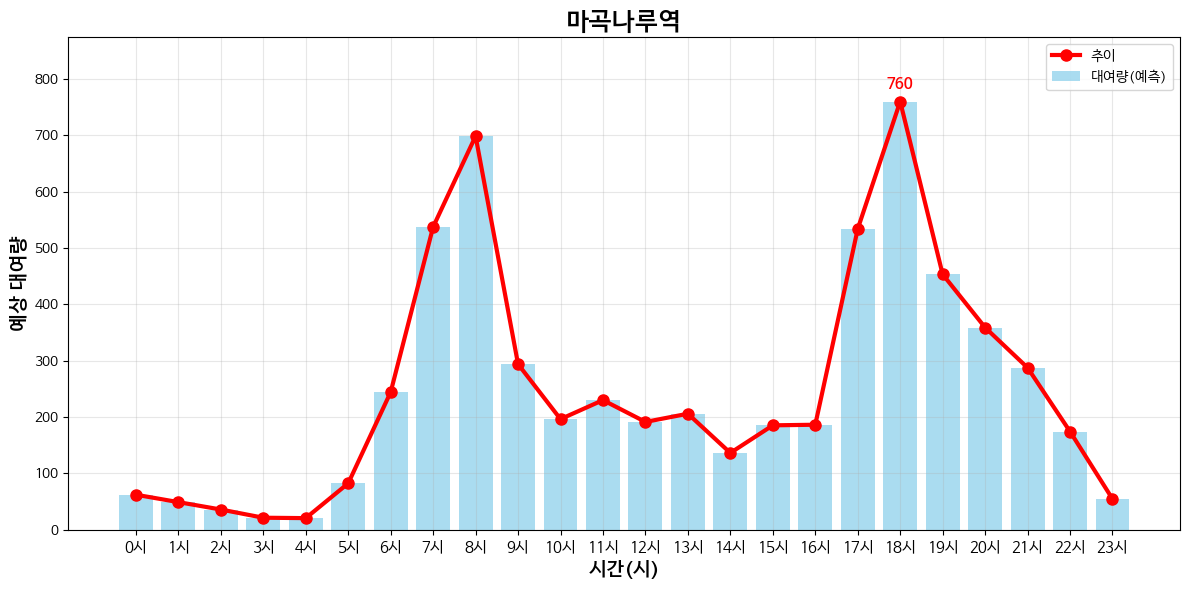

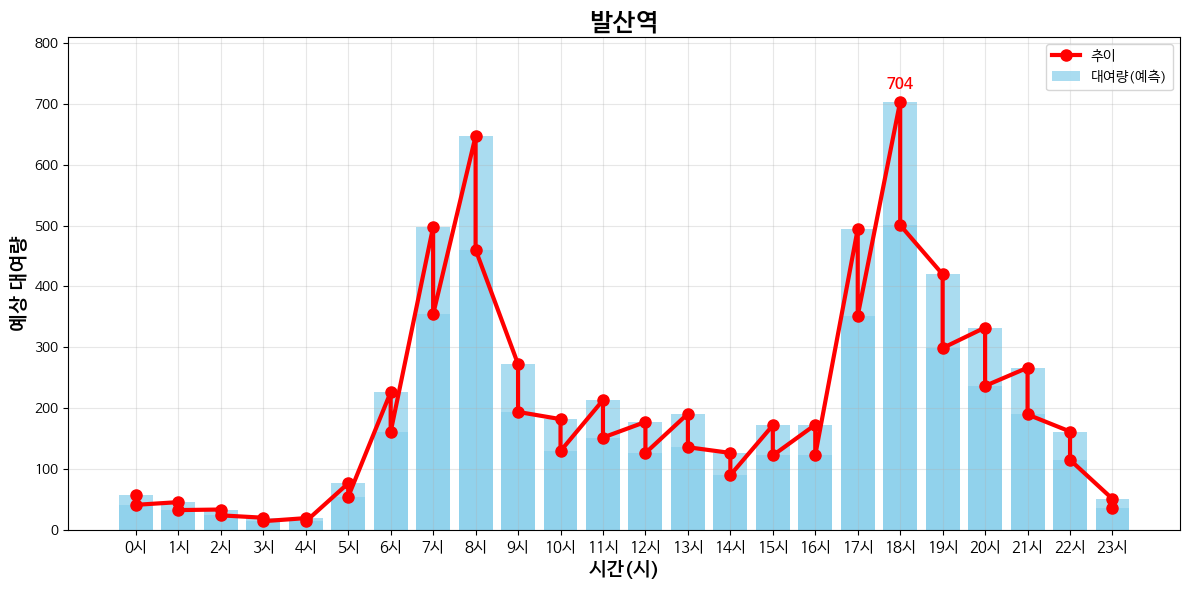

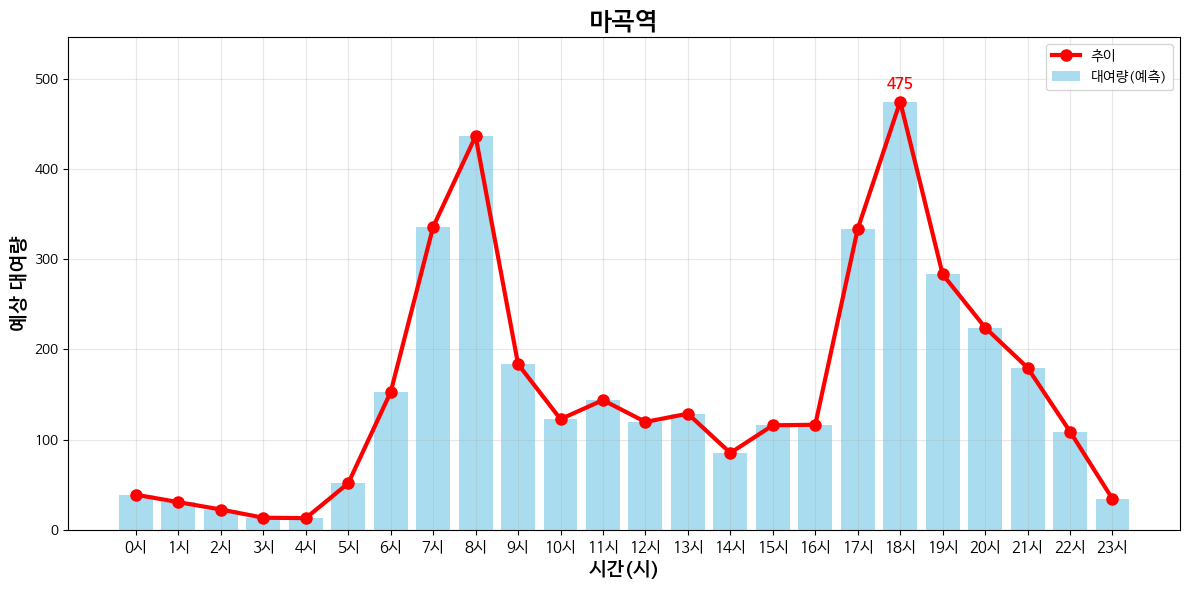

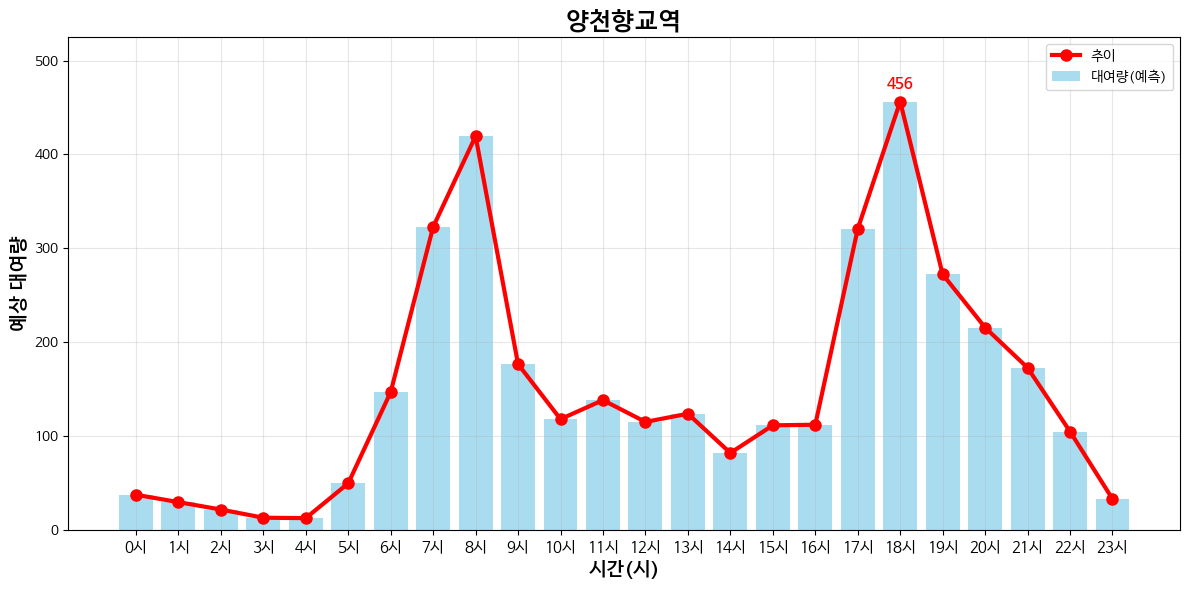

CPU times: total: 3.19 s
Wall time: 36.9 s


In [107]:
%%time
gwanak = check_station_top_five('강서구')